# GCC's ssc-cdi : tomography pipeline for Cateretê v0.6.36
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/

## Imports

In [228]:
import tomopy
from alignment import *
from tomo_processing import *

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import json
import sscCdi
import sscRaft

import os, sys, time, ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imsave
from functools import partial
from concurrent.futures import ProcessPoolExecutor

import sscRaft, sscRadon

from sscCdi.misc import save_json_logfile, create_directory_if_doesnt_exist, save_json_logfile_tomo, open_or_create_h5_dataset
from sscCdi.processing.unwrap import remove_phase_gradient, unwrap_in_parallel


print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscRaft version: {sscRaft.__version__}')

plt.rcParams['image.cmap'] = 'cividis'

sscCdi version: 0.6.39
sscRaft version: 2.2.0


## Load dictionary

In [108]:
dic = {}

## Load data

In [114]:
dic["recon_method"]  = "ptycho" # ptycho or pwcdi
dic["contrast_type"] = "complex" # phase, magnitude or complex
# dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/proposals/20222075/proc/recons/a1_04/2024-01-12-14h01m_a1_04.hdf5"
dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/2023-07-28-14h16m_A2_02.hdf5"

In [115]:
dic = sscCdi.define_paths(dic)

obj, angles = sscCdi.read_data(dic)
print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

In [ ]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles.npy'
# np.save(path,angles)
angles = np.load(path)

In [ ]:
projections_average = np.mean(obj,axis=0)
print(obj.shape,projection.shape)

projection_ROI = np.angle(projections_average) # select abs or angle

plt.figure(dpi=100)
plt.imshow(projection_ROI)

In [ ]:
# sscCdi.deploy_visualizer(np.angle(obj),title='Original sinogram',cmap='gray')

## Crop data

In [ ]:
dic["top_crop"]    = 1300 # n of pixels to remove on top
dic["bottom_crop"] = 2500 # n of pixels to remove on bottom
dic["left_crop"]   = 1200 # n of pixels to remove on left
dic["right_crop"]  = 1400 # n of pixels to remove on right

In [ ]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/cropped.npy'
# cropped_data = tomo_crop(dic,obj,save=False)
cropped_data = np.load(path)
# np.save(path,cropped_data)

In [ ]:
plt.figure()
plt.imshow(np.angle(np.mean(cropped_data,axis=0)))

In [ ]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/cropped.npy'
np.save(path,cropped_data)

## Sort data

In [5]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/sorted.npy'
path2 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles_sorted.npy'
# sorted_data, sorted_angles = tomo_sort(dic,cropped_data, angles,save=False)
# np.save(path,sorted_data)
# np.save(path2,sorted_angles)
sorted_data = np.load(path)
sorted_angles = np.load(path2)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.mean(np.angle(sorted_data),axis=0))

In [ ]:
sscCdi.deploy_visualizer(sorted_data,type='phase',title="Ordered sinogram",cmap='gray')

## Alignment: Cross Correlation (CC) and Vertical Mass Fluctuation (VMF)

In [ ]:
aligned_data_CC = alignment_variance_field(sorted_data, downscaling_factor=1,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

In [ ]:
# sscCdi.misc.deploy_visualizer(aligned_data_CC,type='phase',title='CC',cmap='gray',axis=0) # select axis

In [ ]:
# sscCdi.misc.deploy_visualizer(aligned_data_CC2,type='phase',title='CC',cmap='gray',axis=0) # select axis

In [ ]:
# sscCdi.misc.deploy_visualizer(aligned_data_CC3,type='phase',title='CC',cmap='gray',axis=0) # select axis

In [ ]:
aligned_data_CC2 = alignment_variance_field(sorted_data, downscaling_factor=2,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

In [ ]:
aligned_data_CC3 = alignment_variance_field(sorted_data, downscaling_factor=4,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

In [ ]:
fig, ax = plt.subplots(1,3,dpi=200)
# ax[0].imshow(np.angle(aligned_data_CC[:,aligned_data_CC.shape[1]//2,:]))
# ax[1].imshow(np.angle(aligned_data_CC2[:,aligned_data_CC2.shape[1]//2,:]))
ax[2].imshow(np.angle(aligned_data_CC3[:,aligned_data_CC3.shape[1]//2,:]))

In [18]:
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/aligned.npy'
# np.save(path,aligned_data_CC)
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/aligned2.npy'
# np.save(path,aligned_data_CC2)
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/aligned3.npy'
# np.save(path,aligned_data_CC3)
aligned_data_CC3 = np.load(path)

In [ ]:
# sscCdi.misc.deploy_visualizer(np.angle(aligned_data_VMF),title='VMF',cmap='gray',axis=0) # select axis

In [ ]:
# np.save(dic["pre_aligned_sinogram_filepath"],aligned_data_VMF) # select which prealigned dataset to save

## Unwrap

In [163]:
from sscCdi import unwrap_in_parallel
# unwrapped1 = unwrap_in_parallel(np.angle(aligned_data_CC))
# unwrapped2 = unwrap_in_parallel(np.angle(aligned_data_CC2))
# unwrapped3 = unwrap_in_parallel(np.angle(aligned_data_CC3))

In [13]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrapped1.npy'
unwrapped1 = np.load(path)
# np.save(path,unwrapped1)
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrapped2.npy'
unwrapped2 = np.load(path)
# np.save(path,unwrapped2)
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrapped3.npy'
# np.save(path,unwrapped3)
unwrapped3 = np.load(path)

In [ ]:
# fig, ax = plt.subplots(1,3,figsize=(12,5),dpi=200)
# ax[0].imshow(unwrapped1[:,unwrapped1.shape[1]//2,:])
# ax[1].imshow(unwrapped2[:,unwrapped2.shape[1]//2,:])
# ax[2].imshow(unwrapped3[:,unwrapped3.shape[1]//2,:])

fig, ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(unwrapped1[50:300,unwrapped1.shape[1]//2,50:400])
ax[1].imshow(unwrapped2[50:300,unwrapped1.shape[1]//2,50:400])
ax[2].imshow(unwrapped3[50:300,unwrapped1.shape[1]//2,50:400])

Calculating 1D mass distribution...
Finding shift between neighboor slices...
Shifting slices...
Aligning volume...
Aligning slice #0/550
Aligning slice #50/550
Aligning slice #100/550
Aligning slice #150/550
Aligning slice #200/550
Aligning slice #250/550
Aligning slice #300/550
Aligning slice #350/550
Aligning slice #400/550
Aligning slice #450/550
Aligning slice #500/550


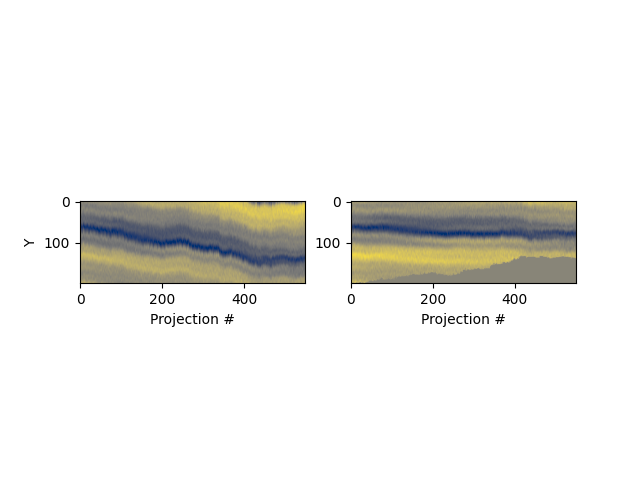

In [208]:
aligned_data_VMF, curves, total_shift = alignment_vertical_mass_fluctuation(aligned_data_CC3, filter_sigma = 2, curve_portion = (100,300), use_phase_gradient = True, return_common_valid_region=True, remove_null_borders = True, plot = 0) # if data is not equalized, phase gradient should be used

Calculating 1D mass distribution...
Calculating 1D mass distribution...


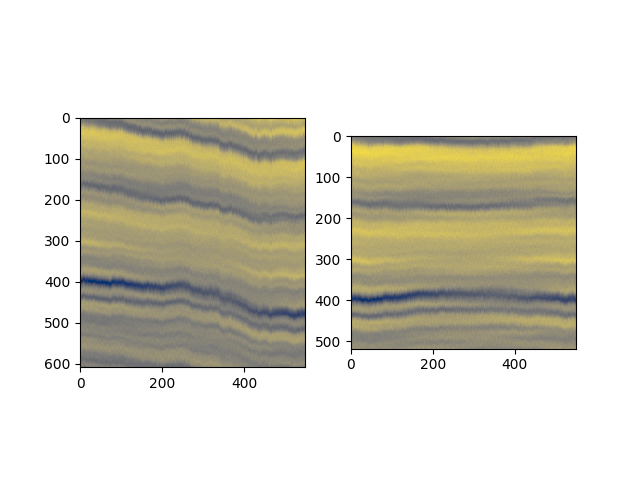

In [209]:
curves0 = get_VMF_curves(aligned_data_CC3,use_phase_gradient=True,filter_sigma=0,curve_portion=None)
curves = get_VMF_curves(aligned_data_VMF,use_phase_gradient=True,filter_sigma=0,curve_portion=None)

fig, ax = plt.subplots(1,2)
ax[0].imshow(curves0.T)
ax[1].imshow(curves.T)

In [210]:
unwrappedVMF = unwrap_in_parallel(np.angle(aligned_data_VMF))

Using 32 parallel processes


100%|██████████| 550/550 [00:22<00:00, 24.10it/s]


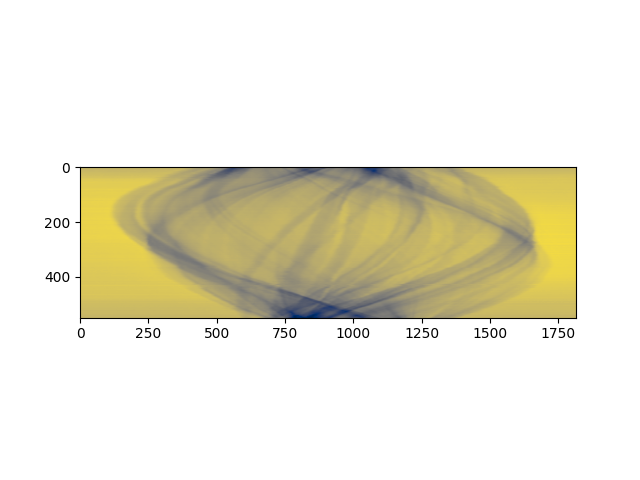

In [211]:
fig, ax = plt.subplots()
# ax.imshow(np.mean(np.angle(aligned_data_VMF),axis=0))
ax.imshow(unwrappedVMF[:,unwrappedVMF.shape[1]//2,:])

## 2D Equalization

In [187]:
dic={}
dic["bad_frames_before_equalization"] = []
dic["CPUs"] = 32

dic["equalize_invert"] = True # invert phase shift signal from negative to positive
# dic["equalize_ROI"] = [500,600,1750,1800] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_ROI"] = [0,50,0,50] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = True  # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_remove_phase_gradient_iterations"] = 5
dic["equalize_local_offset"] = True # remove offset of each frame from the mean of ROI 
dic["equalize_set_min_max"]= [-8,10] # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = False # turn any remaining negative values to zero


In [188]:
equalized_sinogram = tomo_equalize(dic,unwrappedVMF)

Sinogram shape to equalize:  (550, 609, 1815)
Using 32 parallel processes


100%|██████████| 550/550 [00:16<00:00, 34.29it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old -0.75, -4.50, 0.76, 6.02,9.98
New: -3.44, -2.56,1.29, 5.15,10.00
Time elapsed: 31.24 s


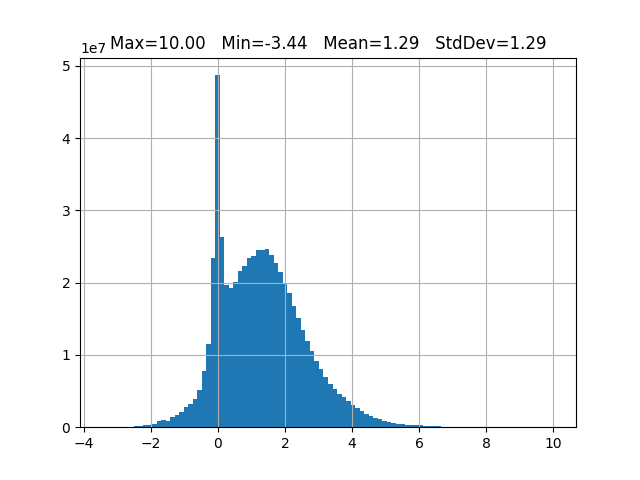

In [189]:
sscCdi.misc.plot_volume_histogram(equalized_sinogram)

In [212]:
sscCdi.deploy_visualizer(-unwrappedVMF,title="Equalized sinogram",cmap='gray',axis=0,aspect_ratio='auto')

In [ ]:
# equalized_sinogram -= np.min(equalized_sinogram)

path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/equalized.npy'
# np.save(path,equalized_sinogram)
equalized_sinogram = np.load(path)

## Tomography: select dictionary according to tomographic method
- for details on the tomography algorithm inputs, see documentation at https://gcc.lnls.br/wiki/docs/ssc-raft/reconstructions/

In [223]:
dic = {}
dic['using_wiggle'] = False
dic["project_angles_to_regular_grid"] = False

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

dic["algorithm_dic"] = { # if FBP: filtered back-projection
    'algorithm': "FBP",
    'gpu': [0],
    'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
    'regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
    'shift center':0,
}

# dic["algorithm_dic"] = { # if eEM: emission expectation maximization
#     'algorithm': "EM",
#     'gpu': [0],
#     'regularization': 0.1,
#     'method': 'eEM', 
#     'niterations': [20,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
#     'epsilon': 1e-15, #for EMTV only
#     'blocksize': 20, # blocks for parallelization
# }

In [224]:
# # sinogram = np.load(dic["equalized_sinogram_filepath"])
# sinogram = np.load(dic["wiggle_sinogram_filepath"])

dic["ordered_angles_filepath"] = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles_sorted.npy'
# a = unwrappedVMF - np.min(unwrappedVMF)
recon3D2 = tomo_recon(dic,-unwrappedVMF,save=False)

path =  '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_EM20_VMF.npy'
# np.save(path,recon3D2)

Starting tomographic algorithm FBP algorithm
Using default - precision : float32
Using default - threshold : 0
	 Tomography done!
Time elapsed: Tomography: 8.183387994766235 s


In [ ]:
sscCdi.deploy_visualizer(recon3D,title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

In [226]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_EM20.npy'
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_FBP.npy'
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_EM40.npy'
# np.save(path,recon3D2)

recon3D = np.load(path)

In [ ]:
projection3D = np.sum(recon3D,axis=1)

In [ ]:
path = '/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/tomo_20iter/2023-07-28-14h16m_A2_02_complex_tomo_equalized.npy'
path = '/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/retomo_40iter/2023-07-28-14h16m_A2_02_complex_tomo_equalized.npy'
recon3D2 = np.load(path)
print(recon3D2.shape)
projection3D2 = np.sum(recon3D2,axis=1)


In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,5),dpi=200)
ax[0].imshow(equalized_sinogram[277]), ax[0].set_title('Ptycho') 
ax[1].imshow(projection3D), ax[1].set_title('New CC ')
ax[2].imshow(projection3D2[100:750,0:-20]), ax[2].set_title('Old CC ')


In [ ]:
# aligned_tomopy =  tomopy.prep.alignment.align_joint(equalized_sinogram, sorted_angles[:,1]*np.pi/180, fdir='./', iters=20, pad=(0, 0), blur=True, center=None, algorithm='sirt', upsample_factor=10, rin=0.5, rout=0.8, save=True, debug=True)

path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomopy_seq.npy'
# np.save(path,aligned_tomopy[0])
aligned = np.load(path)

In [198]:
# tomo3D = tomopy.recon(unwrapped3, sorted_angles, algorithm='sirt',ncore=32)

In [220]:
recon3D2[recon3D2>20] = 0
# sscCdi.misc.plot_volume_histogram(recon3D2)

Text(0.5, 1.0, 'CC+VMF+EM')

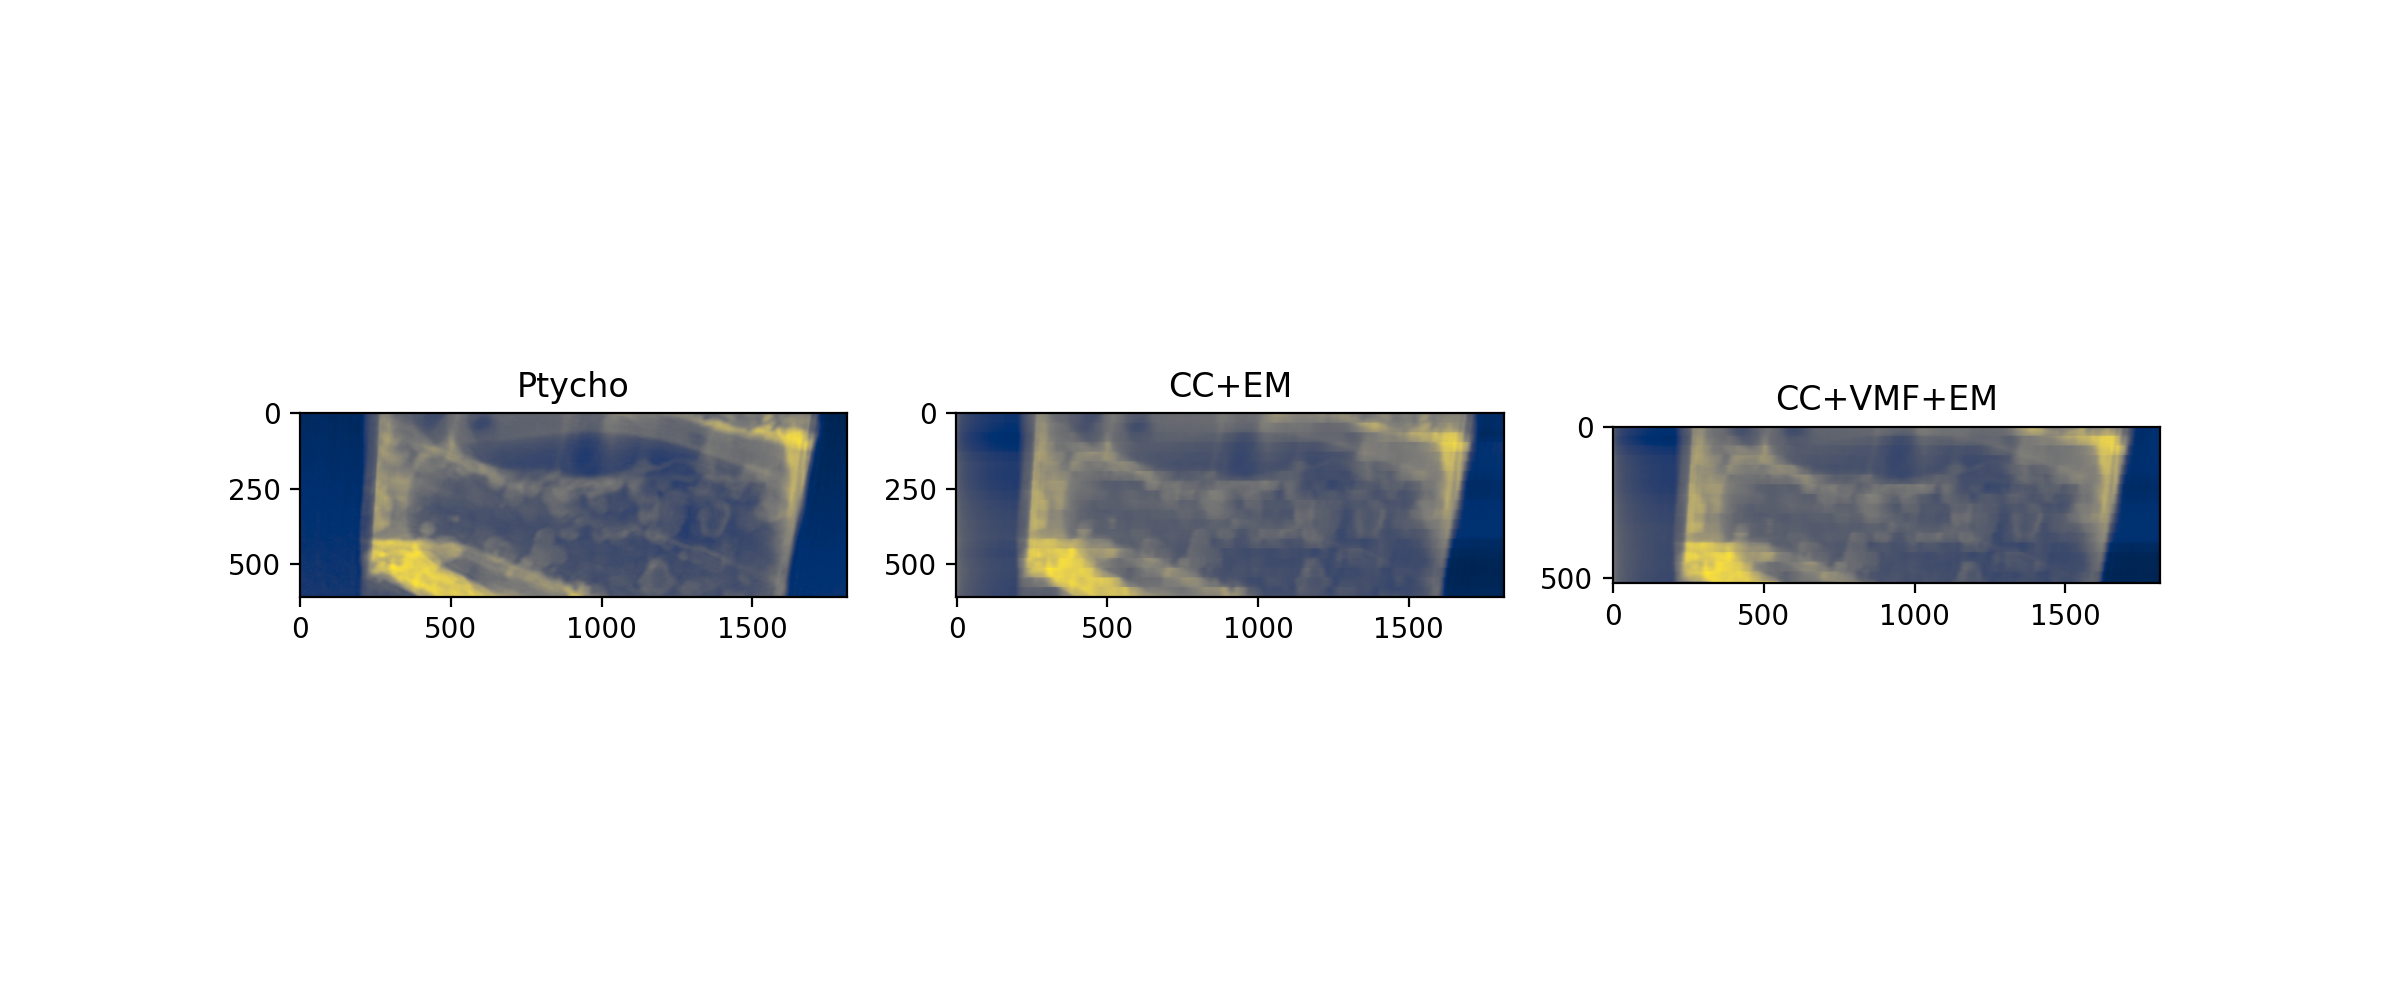

In [227]:
fig, ax = plt.subplots(1,3,figsize=(12,5),dpi=200)
ax[0].imshow(-unwrapped3[275])
ax[1].imshow(np.sum(recon3D,axis=1))
ax[2].imshow(np.sum(recon3D2,axis=1))#,norm=LogNorm())
ax[0].set_title('Ptycho')
ax[1].set_title('CC+EM')
ax[2].set_title('CC+VMF+EM')